In [1]:
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

# Variables

In [2]:
x_final = 120
y_final = int(0.75 * x_final)

extension_m = 108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

search_x = [-1000000, -1450000, -1750000, -1400000]

# Set up

In [3]:
x_region, y_region, z_region = functions_plot.def_regionS()
cmap, norm = functions_plot.Colormap()

# 1. Mackenzie Canyon Dimensions

In [4]:
w_break, w_mid, w_head, width_f, x_wall, mouth, length, y_wall_1300, y_wall, adjust, cR, L, y_base, y_break,\
y_coast, y_head, fluid_depth, z_bottom, z_break, z_wall, p = functions_idealized.define_Mackenzie_measurements()

# 2. Base Region

In [5]:
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

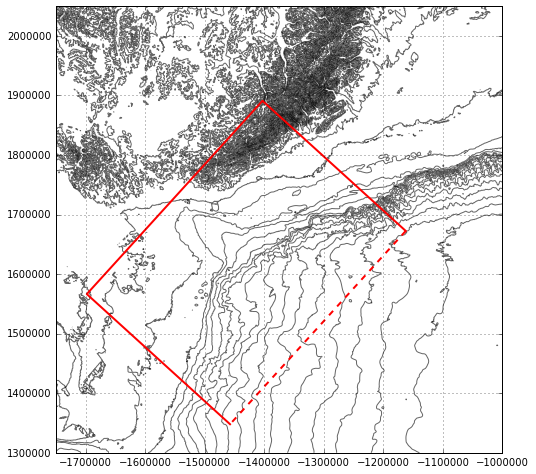

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.plot(lon_s_corners_can, lat_s_corners_can, 'r', linewidth=2)
ax.plot(lon_s_corners_can[::3], lat_s_corners_can[::3], 'r', linewidth=2, linestyle='--')

# 3. Extended Region

In [7]:
x_wall_ext = x_wall + extension_m

In [8]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

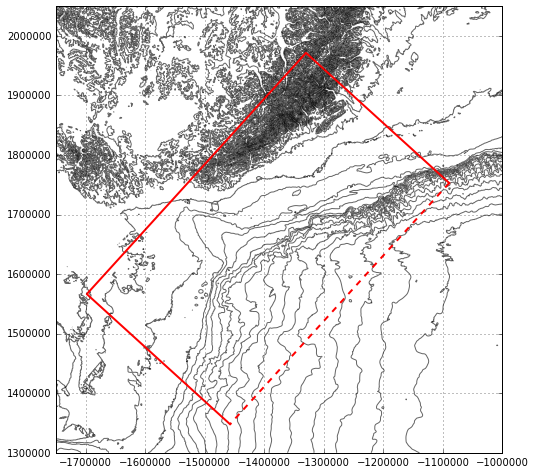

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
ax.plot(lon_s_corners[::3], lat_s_corners[::3], 'r', linewidth=2, linestyle='--')

# 4. Extended Coordinates

In [10]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

lon_g_grid, lat_g_grid = functions_grid.create_grid(x_final, y_final, lonW, latW, lonE, latE)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

4.50141506581
4.50141337134


(120, 90)

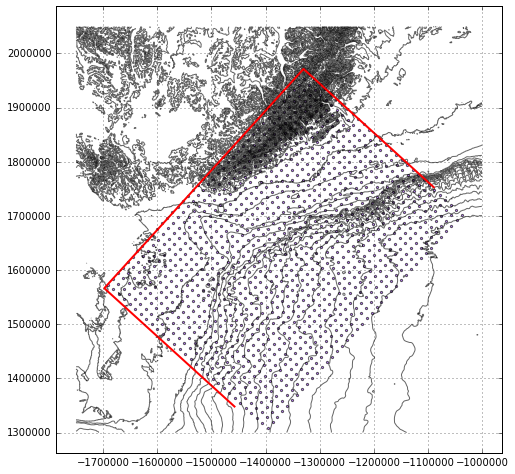

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.scatter(lon_s_grid[::3,::3], lat_s_grid[::3,::3], c='BlueViolet', s=5, alpha=0.6)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
lon_s_grid.shape

# 5. Extended Bathymetry

In [ ]:
z_canyon = functions_realistic.extract_canyon(lon_s_grid, lat_s_grid, x_region, y_region, z_region)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_canyon, 30, cmap=cmap)
ax.contour(z_canyon, 30, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_canyon.shape

In [ ]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
index = int(extension_m / (dx * 1000))

In [ ]:
z_cyclic = functions_realistic.cyclic_canyon_truncate(index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_cyclic, 30, cmap=cmap)
ax.contour(z_cyclic, 30, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_cyclic.shape

In [ ]:
z_model = functions_realistic.canyon_for_model(fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_model, 30, cmap=cmo.cm.matter)
ax.contour(z_model, 50, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_model.shape

In [ ]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

In [ ]:
difference = np.subtract(z_smoothed, z_original)
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].contourf(z_original, 50, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 50, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, 25, linestyles='solid', colors = 'k')
axes[1].contour(z_smoothed, 25, linestyles='solid', colors = 'k')
axes[2].contour(z_original, levels = [0, 40, 80, 1299], colors='k',linestyles='-')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

# 7. Idealized Canyon

In [15]:
xsize, ysize = x_final-2, y_final-2

In [16]:
x_wall_ideal = x_wall_ext

p_one = [lon_s_grid[-1,-1], lat_s_grid[-1,-1]]
p_two = [lon_s_grid[-1,0], lat_s_grid[-1,0]]
y_wall_ideal = functions_grid.find_distance(p_one, p_two)

y_diff = y_wall_ideal - y_wall

y_base_ideal = y_base + y_diff
y_break_ideal = y_break + y_diff
y_head_ideal = y_head + y_diff
y_coast_ideal = y_coast + y_diff

In [17]:
x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall_ideal, y_wall_ideal)

z_ideal = functions_idealized.make_topo_smooth(y_edge, y_base_ideal, y_break_ideal, y_head_ideal, y_coast_ideal,
                                               cR, L, x, x_wall_ideal, w_break, w_mid, w_head, p,
                                               fluid_depth, z_bottom, z_break, z_wall)

(87, 117)

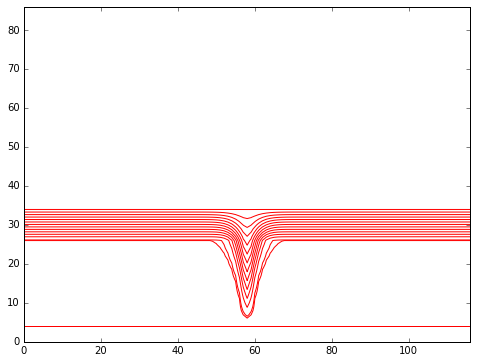

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.contour(z_ideal, 15, linestyles='solid', colors = 'r')
ax.contour(z_ideal, levels = [0, 40, 80, 1299], colors='r')
#ax.contour(z_smoothed, 15, linestyles='solid', colors = 'k')
#ax.contour(z_smoothed, levels = [0, 40, 80, 1299], colors='k')
z_ideal.shape

# 8. Make files

1. Coordinates Grid 
2. Idealized canyon bathymetry

In [13]:
filename = 'grid_01.nc'
title = 'Mackenzie Coordinate Grid 01'
description = '90x120. Extended on the west by 108061 m. dx, dy = 4.5 km. Smoothed'
ipynbname = 'final_bathymetry.ipynb'
functions_grid.create_grid_file(x_final, y_final, lon_g_grid, lat_g_grid, filename, title, description, ipynbname)

In [19]:
filename = 'ideal_bathy_01.nc'
title = 'Idealized Bathymetry Version 01'
description = 'Result of the original topo code. 87x117. Centred gaussian. No finer modifications.'
ipynbname = 'final_bathymetry.ipynb'
functions_idealized.create_bathy_file(X, Y, z_ideal, filename, title, description, ipynbname)